In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(1) # Ensure random number generation if needed

In [28]:
training = [("The bear mauled the coyote".split(), ["DET", "NN", "V", "DET", "NN"]),
            ("Smokers despise themselves some would say, not me though".split(), ["NN", "V", "DET", "DET", "V", "V", "DET", "NN", "DET"])]

In [29]:
def word_wise_indexing(text, text_index):
    sequence = text
    element_index = [text_index[word_element] for word_element in sequence]
    return torch.tensor(element_index, dtype=torch.long)

In [30]:
training_data_index = {}

In [31]:
for sentence, tags in training:
    for word in sentence:
        if word not in training_data_index:
            training_data_index[word] = len(training_data_index)

# print(training_data_index)

tag_index = {"DET": 0, "NN": 1, "V": 2}

embedding_dims = 6
hi_hidden_dims = 6

In [32]:
class LSTMTagger(nn.Module):

    def __init__(self, emb_dim, hi_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hi_dim = hi_dim

        self.word_embeddings = nn.Embedding(vocab_size, emb_dim)

        self.lstm_model = nn.LSTM(emb_dim, hi_dim)

        self.transform_into_tag_space = nn.Linear(hi_dim, tagset_size)
    
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        
        # The view() function below reshapes the tensor to satisfy the dimension perameters of the lstm function (sentence length, batch size, embedding dimensions).
        model_output, _ = self.lstm_model(embeds.view(len(sentence), 1, -1)) 

        model_output = model_output.view(len(sentence), self.hi_dim)
        
        # The view() function is used again prior to calling the 2D linear transformation function designed to map the LSTM model's hidden state to tag space.
        tag_space = self.transform_into_tag_space(model_output) # Returns a 2D tensor

        # The log_softmax() function converts the model output score into log-probabilities for all elements in the tag space/original sequence (dim=1).
        scores = F.log_softmax(tag_space, dim=1)

        return scores




In [33]:
lstm_model_run_one = LSTMTagger(embedding_dims, hi_hidden_dims, len(training_data_index), len(tag_index))
fn_loss = nn.NLLLoss()
fn_optimization = optim.SGD(lstm_model_run_one.parameters(), lr=0.1)

In [34]:
with torch.no_grad():
    input_data = word_wise_indexing(training[0][0], training_data_index)
    scores_for_tags = lstm_model_run_one(input_data)
    
    # print(scores_for_tags)

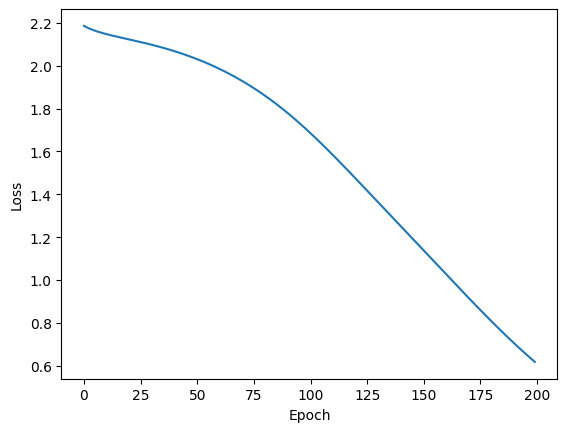

In [35]:
loss = []
for epoch in range(200):
    loss_val = 0
    for sentence_sequence, assoc_tags in training:
        
        lstm_model_run_one.zero_grad()

        input_segment = word_wise_indexing(sentence_sequence, training_data_index)

        target_entities = word_wise_indexing(assoc_tags, tag_index)

        seq_sen_score = lstm_model_run_one(input_segment)

        with_fixed_loss_fn = fn_loss(seq_sen_score, target_entities)
        with_fixed_loss_fn.backward()
        fn_optimization.step()
        loss_val += with_fixed_loss_fn.item()

    loss.append(loss_val)
        
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [36]:
with torch.no_grad():
    input_data_post_training = word_wise_indexing(training[0][0], training_data_index)

    post_training_scores = lstm_model_run_one(input_data_post_training)

    # print(post_training_scores)